# Practical Lab 4
So far, we have described various methods and libraries more or less in isolation on traditional datasets. In this lab, we will try to bring all that you have learned in the previous practical labs into one, as well as demonstrate important aspects of how you train machine learning models on real-world projects, investigate and pre-process your data, etc.

We will start by downloading a dataset about cars. The dataset contains six columns with some information regarding the cars, and one column with the acceptability. The information that is given to us is:

- **The buying price**: very high (*vhigh*), high (*high*), medium (*med*), low (*low*)
- **The price of the maintenance**: very high (*vhigh*), high (*high*), medium (*med*), low (*low*)
- **Number of doors**: 2 (*2*), 3 (*3*), 4 (*4*), 5 or more (*5more*)
- **Capacity in terms of persons to carry**: 2 (*2*), 4 (*4*), more than 4 (*more*)
- **The size of luggage boot**: small (*small*), medium (*med*), big (*big*)
- **Estimated safety of the car**: low (*low*), medium (*med*), high (*high*)

Each car will also be given one out of four **acceptability class values**: unacceptable (*unacc*), acceptable (*acc*), good (*good*), very good (*vgood*).

In this lab we will train a classifier on this dataset and find the best model to fit the data, i.e. we are going to classify if people want to buy the car based on the features or not.

In [180]:
# Dataset and info found at the website
# https://archive.ics.uci.edu/ml/datasets/car+evaluation

import urllib.request
import pandas as pd
url = 'https://raw.githubusercontent.com/MarkusSagen/ML-datasets/master/cars_data.csv'
urllib.request.urlretrieve(url, 'cars_data.csv')
df = pd.read_csv('cars_data.csv', index_col=0)

Utility functions:

In [181]:
import warnings
warnings.filterwarnings('ignore')

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Helper to print with prettier colors
class c:
    PURPLE = '\033[95m'
    BLUE = '\033[94m'
    CYAN = '\033[96m'
    GREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    END = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    
print(f"Printing {c.PURPLE}with {c.GREEN}pretty {c.FAIL}colors{c.END}{c.BOLD}!{c.END}")

Printing with pretty colors!


Inspect the dataset:

In [183]:
df.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,NaN,2,small,low,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [184]:
len(df)

1728

### Renaming the columns of our dataset 
Using the information about the dataset we gathered from the original website, we can now rename the columns of the dataset.

In [185]:

column_names = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]

df.columns = column_names
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,NaN,2,small,low,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


### Preprocess and formating your data
Something we have touched upon a bit in previous labs is the importance of cleaning and transforming the data in such a way that it is easier for you and the machine learning models to work with.    

We have actually cheated a bit... The dataset you have received has been modified to include some missing values. This is common in real-world datasets and something you need to deal with first! Machine learning models don't know how to fit a missing value, and it is therefore your job as a machine learning expert to choose one of several ways of how to deal with missing data ;-)   

By printing out the information for each column, we can compare quickly if any of the columns contain missing values. Please note that the features such as `.head()`, `.info()`, etc. are features built into the Pandas library!

In [186]:
nan_values_per_feature = df.isnull().sum()
nan_total = sum(list(df.isnull().sum()))

print(f"The dataset length: \t\t{c.BLUE}{len(df)}{c.END}")
print(f"Total number of missing values: {c.BOLD}{nan_total}{c.END}\n")

print(f"{c.BOLD}Printing how many entries in each column contain no NaN values{c.END}:")
df.info()

The dataset length: 		1728
Total number of missing values: 8

Printing how many entries in each column contain no NaN values:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1725 non-null   object
 1   maint     1728 non-null   object
 2   doors     1723 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 108.0+ KB


#### ASSIGNMENT a)
Remove or handle the missing values in the dataset in an appropriate way.
- **HINT**: Pandas have multiple built-in methods for dealing with missing values.

In [187]:
df.dropna(inplace=True)

Let's inspect the dataset a bit more. What kind of value does each column contain?
Let's print the content of each column.

In [188]:
print("List all attributes in the dataset and count how many entries of each kind\n")
for col in column_names:
    print(f"{c.BOLD}{col}:{c.END}")
    print(f"{df[col].value_counts()}")
    print()

List all attributes in the dataset and count how many entries of each kind

buying:
high     432
med      431
low      430
vhigh    428
Name: buying, dtype: int64

maint:
med      432
low      431
high     430
vhigh    428
Name: maint, dtype: int64

doors:
5more    432
4        431
2        430
3        428
Name: doors, dtype: int64

persons:
more    575
2       574
4       572
Name: persons, dtype: int64

lug_boot:
small    574
med      574
big      573
Name: lug_boot, dtype: int64

safety:
low     574
med     574
high    573
Name: safety, dtype: int64

class:
unacc    1205
acc       382
good       69
vgood      65
Name: class, dtype: int64



### Feature Engineering

From this we can observe several things:
- There is a very even distribution of attributes in all categories.
- All categories consist of categorical attributes (since no feature has only numbers).
- Even the number of doors is a categorical value since it is grouped into having "_5orMore_" as a possible attribute.
- Since ML models don't know how to order categorical values such as "_small_", "_medium_", "_big_", we first need to convert the categorical values into numerical representations. This will ensure that the machine learning model knows how to order and compare the different features.

In [189]:
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
5,vhigh,vhigh,2,2,med,high,unacc


#### Assignment b)
Convert all the features in the dataset from categorical values into ordinal data/numerical data.
- There are multiple ways of doing this both with Pandas, Scikit-learn, or even external libraries dedicated to doing just this sort of thing.
- Search online for methods for converting categorical data into numerical or ordinal data.
- Do not spend too much time on this. Make it **SIMPLE!**.
- Your goal is to classify the data and all these pre-processing methods are steps to get you towards that goal.

In [190]:
from pandas.api.types import is_numeric_dtype as is_num

cn_map = {'low':0, 'med':1, 'high':2, 'vhigh':3}
df['buying'] = df['buying'].map(cn_map)

cn_map = {'low':0, 'med':1, 'high':2, 'vhigh':3}
df['maint'] = df['maint'].map(cn_map)

cn_map = {'2':0, '3':1, '4':2, '5more':3}
df['doors'] = df['doors'].map(cn_map)

cn_map = {'2':0, '4':1, 'more':2}
df['persons'] = df['persons'].map(cn_map)

cn_map = {'small':0, 'med':1, 'big':2}
df['lug_boot'] = df['lug_boot'].map(cn_map)

cn_map = {'low':0, 'med':1, 'high':2}
df['safety'] = df['safety'].map(cn_map)

cn_map = {'unacc':0, 'acc':1, 'good':2, 'vgood':3}
df['class'] = df['class'].map(cn_map)

# CODE FOR CHECKING THE FORATING OF THE DATASET
assert is_num(df['buying']),   "The 'buying' column contained categorical values"
assert is_num(df['maint']),    "The 'maint' column contained categorical values"
assert is_num(df['doors']),    "The 'doors' column contained categorical values"
assert is_num(df['persons']),  "The 'persons' column contained categorical values"
assert is_num(df['lug_boot']), "The 'lug_boot' column contained categorical values"
assert is_num(df['safety']),   "The 'safety' column contained categorical values"
assert is_num(df['class']),    "The 'class' column contained categorical values"

Once the data is finally numeric, we can do things like plot the distribution of the data, draw a histogram, or similar. In some steps above, we sprinted how many attributes we had in each column, but now we can instead inspect it visually. A very handy library for making more complex and comparative plots is a library called [`seaborn`](https://seaborn.pydata.org/examples/index.html). We know this will be a very even distribution among the features, but it is good practice to do, especially when you are working with more complex datasets!  

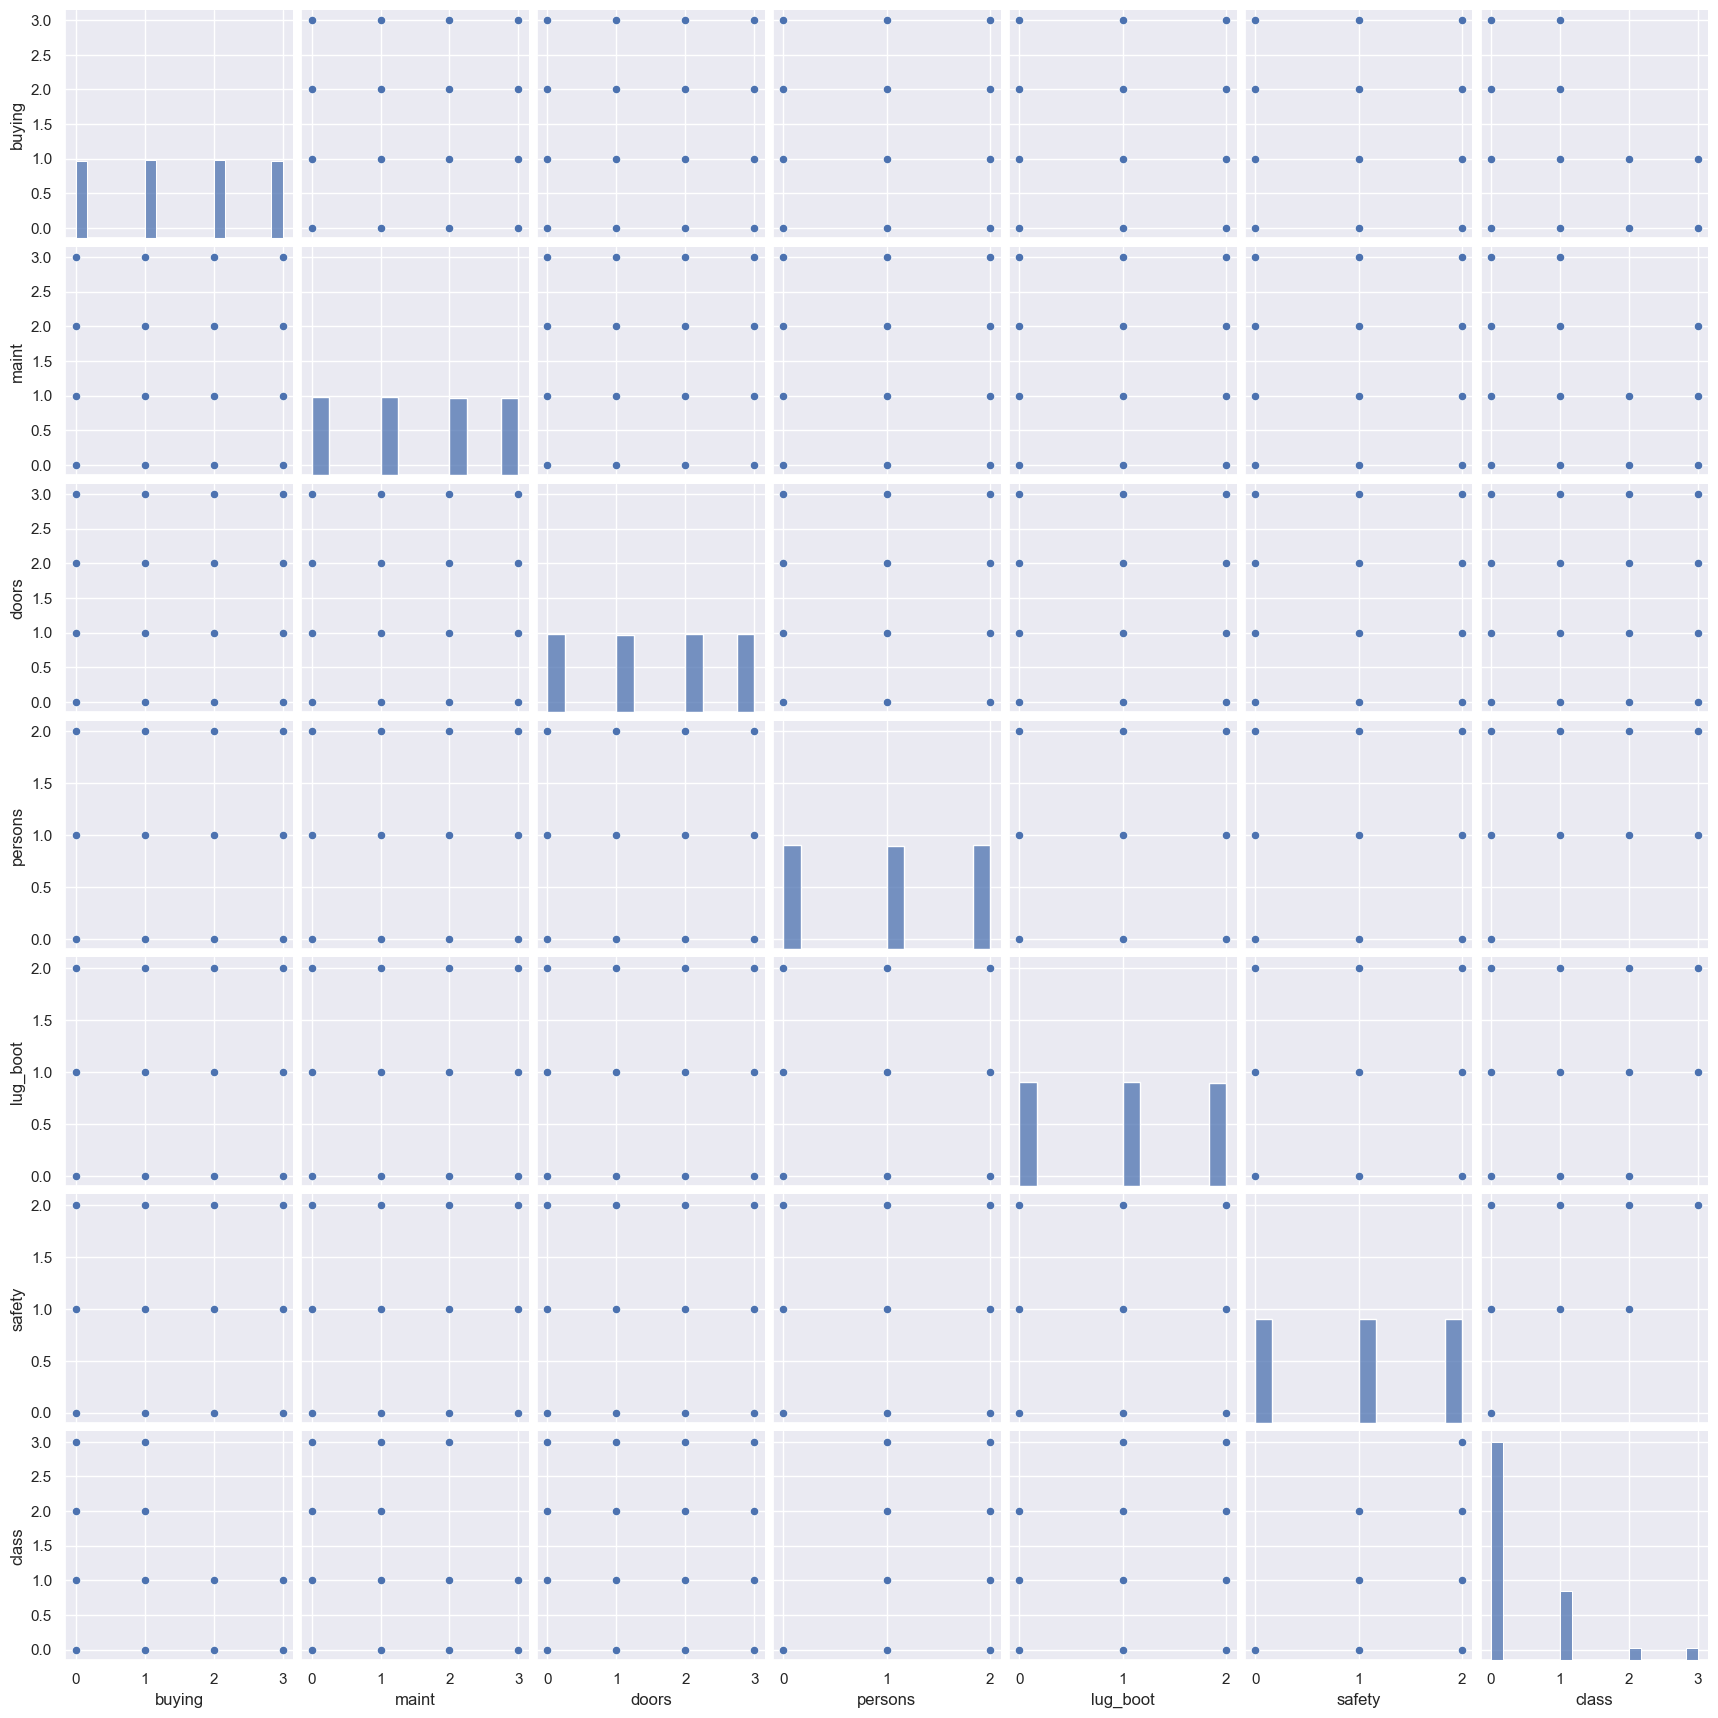

In [191]:
import seaborn as sns
sns.pairplot(df)
plt.show()

### Finishing up on the pre-processing

The final step of the pre-processing steps is to split the dataset into features $X$ and label $y$ - Meaning all the features we want the model to use when training is in X, and the label, what the model tries to predict, is filtered out and used in a separate dataset. If we do not remove the labels for the dataset, the model will learn to only look at those features and not actually learn.   
  
Once we have the data divided into features and labels, we split each of them into a `training` and `testing` set before training and evaluating our model.  
  
Note that there are many pre-processing and feature engineering steps that we did not cover which one could do like One-Hot Encoding. For regression problems, for instance, it is common to normalize the data - making it more stable to variance between the values.

#### Assignment c)
- Divide the dataset into two datasets, one containing only the features and one containing only the labels you later want to predict
- Split the features and labels into training and testing sets. Choose a split you think seems reasonable.


In [192]:
from sklearn.model_selection import train_test_split

X = df.drop('class', axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


## Training a simple classifier

Let's create a simple classifier to predict if people want to buy a car or not.  
We will start by using a Logistic Regression model.

#### Assignment d)
- Create a Logistic Regression model similar to what you did in practical lab3.
- Train your model on the training data set you just created and evaluate it against the test dataset you created in the section above.
- Compute the accuracy between your predicted labels and the actual labels.
- **HINT**: If you set your training or testing dataset in the above section with an improper division (too much data in either dataset), then the test below will fail. 

In [193]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
acc = accuracy_score(y_test, y_pred)



# CODE PROVIDED TO TEST YOUR MODEL
assert 0.7 <= acc <= 0.95, "Your train/split division have too much data in the train or test set\
                            \nTry to change the division to create a more balanced model"

print(f"The trained model has an accuracy of: {100*acc:.2f}")

The trained model has an accuracy of: 82.32


Not bad at all! But can we do better???   
The performance of the model depends on several things, such as the choice of model, its hyperparameters, the random seed used when initializing training, the train/split ratio when partitioning the datasets, etc.   

Choosing between all possible parameters that could improve the model is a vast topic all of itself called **Hyper-parameter tuning**. We will not discuss it more here in this lab, only mention that it exists and that two commonly used techniques for finding the optimal hyperparameters are *Grid search* and *Bayesian optimization*.

## Cross-validation (CV) 


To prevent overfitting when evaluating different methods and settings one can  partition the available data into three sets instead; training, validation, and test set. But this will drastically reduce the number of samples which can be used for learning the model. A solution to this problem is a procedure called Cross-validation (CV), where a validation set no longer is needed.

You can read more about CV [here](https://scikit-learn.org/stable/modules/cross_validation.html). (And we strongly recommend you to read about this for a better understanding).


#### ASSIGNMENT e)
We will now look into some other classifiers, and try them against each other using CV. Investigate the five classifiers
SVC ([Guide](https://scikit-learn.org/stable/modules/svm.html#svm-classification), [code](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)), 
SVC-linear ([Guide](https://scikit-learn.org/stable/modules/svm.html#svm-classification), [code](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)), 
decision trees ([Guide](https://scikit-learn.org/stable/modules/tree.html#tree), [code](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)), 
k-NN ([Guide](https://scikit-learn.org/stable/modules/neighbors.html#classification), [code](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)), 
and random forest ([Guide](https://scikit-learn.org/stable/modules/ensemble.html#forest), [code](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)), 
and choose at least three of them for this exercise. Run them against each other using CV (*with for example 10 runs*), and evaluate the performance by finding the average accuracy for each model. Print the result for each models average performance and determine which model you would choose, based on this.
When you run these models, make sure that you pass in `random_state=42` as an argument, or some other number as your random state to ensure consistent training when you try to re-run the experiment.

You are encouraged to explore [more algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) as well.

<br>

**HINT**: When using cross-validation you do not need to make a train/test-split, since it does it automatically.

In [194]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = svm.SVC(kernel='linear', random_state=42)
lin_scores = cross_val_score(clf, X, y)

print("SVC-linear had a  %0.2f accuracy with a standard deviation of %0.2f" % (lin_scores.mean(), lin_scores.std()))

clf = DecisionTreeClassifier(random_state=42)
DT_scores = cross_val_score(clf, X, y)

print("Decision Tree Classifier had a  %0.2f accuracy with a standard deviation of %0.2f" % (DT_scores.mean(), DT_scores.std()))

clf = RandomForestClassifier(random_state=42)
RF_scores = cross_val_score(clf, X, y)

print("Decision Tree Classifier had a  %0.2f accuracy with a standard deviation of %0.2f" % (RF_scores.mean(), RF_scores.std()))


SVC-linear had a  0.78 accuracy with a standard deviation of 0.10
Decision Tree Classifier had a  0.80 accuracy with a standard deviation of 0.07
Decision Tree Classifier had a  0.82 accuracy with a standard deviation of 0.05


We have now seen how cross-validation can be used to more fairly compare the overall performance between different models. However, cross-validation can also be used when testing different hyper-parameters to find, on average, which hyper-parameters creates the best model with a trade-off between over- and underfitting?  
  
We provide some optional assignments for those who wish to investigate it further, but, again, it is __not__ mandatory.

## Interpreting a model and feature selection

Up until now we have used all the features of the model to make our predictions. However, machine learning models will try to use all the available features it has from the dataset to best fit the model, even if some features are not needed. This can lead to the model performing worse when using all the features, compared to a handful of them. We will demonstrate this in the final part of the notebook.   
  
Machine learning models often require vast amounts of data and perform worse the less training data it has. We will illustrate both these cases in the final part of the lab.

#### ASSIGNMENT f)
- Train and fit a Random Forest classifier using the train/test split of (20/80) for the training and testing - meaning it uses very little data for its training.

Generally the more data it has to train on, the better it performs and the more features to use, the more complex and reliant on a vast amount of data the model becomes.

<br>
We will use the Random Forest classifier you trained here to showcase how one can view the feature importance when clearing a classifier. We will also use it to showcase how we can remove certain features, build a new classifier and potentially get even better accuracy by removing certain features. This is especially true when you have a lot of features or few data samples available for training!

In [195]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
clf =RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

assert 0.9 <= acc <= 0.96, "The train/test split should be (20/80)"
print(f"The model accuracy is: {c.BOLD}{acc:.2f}{c.END}")

The model accuracy is: 0.93


In [196]:
feature_scores = pd.Series(clf.feature_importances_, index = X_train.columns).sort_values(ascending = False)

Set a nice color palette.

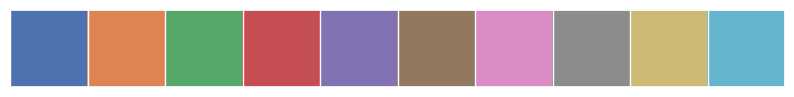

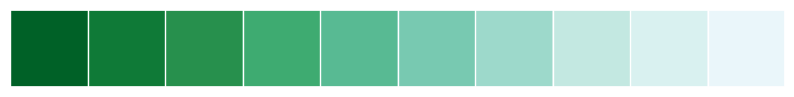

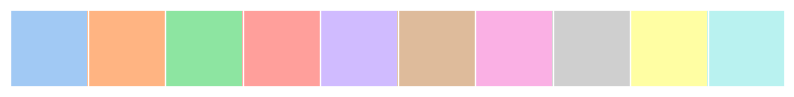

In [197]:
# We can choose different color schemes when plotting
import seaborn as sns
sns.palplot(sns.color_palette("deep"))
sns.palplot(sns.color_palette("BuGn_r", 10)) 
sns.palplot(sns.color_palette("pastel"))

# Set the color palette we want to use
sns.set_palette('pastel', n_colors=7)

##### Plot the importance of each feature according to our trained classifier

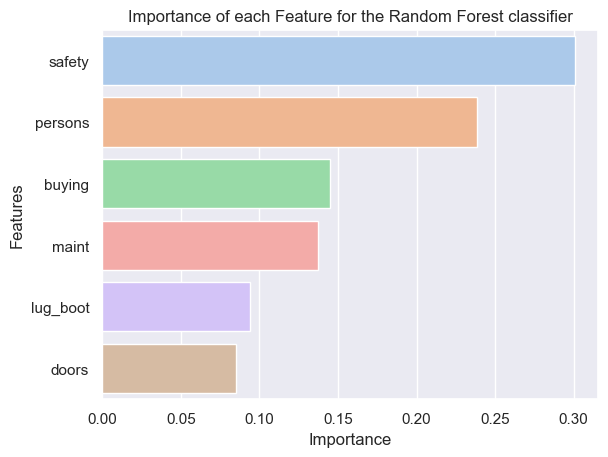

In [198]:
sns.barplot(x=feature_scores, y=feature_scores.index, )
plt.title("Importance of each Feature for the Random Forest classifier")
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

From this we can conclude that both the feature `doors` and `lug_boot` does not seem too important for the classifier.  

We therefore try to create a new classifier with a dataset where we have removed one of those features, we can start by removing the `doors` feature, but feel free to remove the other feature or even both of them and see what happens to the performance.

In [199]:
X_train_new = X_train.drop(['doors'], axis=1)
X_test_new = X_test.drop(['doors'], axis=1)


clf.fit(X_train_new, y_train)
pred = clf.predict(X_test_new)
acc = accuracy_score(y_test, pred)
print(f"The accuracy after dropping one of the feature is now: {c.BOLD}{acc:.2f}{c.END}")

The accuracy after dropping one of the feature is now: 0.91


We can see that the performance increased from about 0.93 to about 0.94 by only removing one of the least significant features.   

We will plot the confusion matrix for our newly created classifier to get some insights on which labels the models performs well or not.

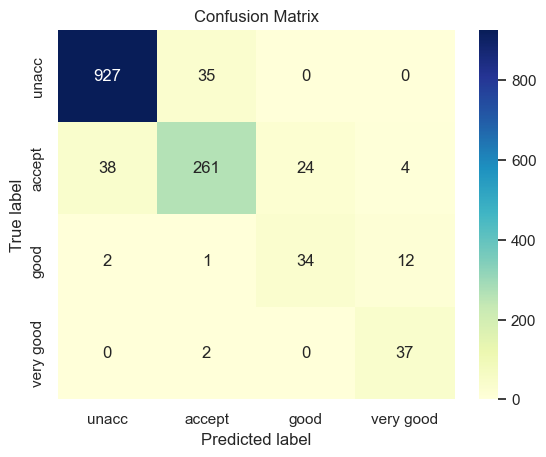

In [200]:
# Import the necessary packages
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

car_condition = ['unacc', 'accept', 'good', 'very good'] # Labels of the target variable

conf_matrix = confusion_matrix(pred, y_test); # Set to None to show the actual numbers

# Display an aesthetic confusion matrix with colours:
sns.set(font_scale = 1)
sns.heatmap(conf_matrix, annot = True, cmap="YlGnBu", fmt = 'd', xticklabels = car_condition, yticklabels = car_condition)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

A confusion matrix is a table that is used to define the performance of a classification algorithm. It is used to evaluate the accuracy of a classifier. It is a table with 4 different combinations of predicted and actual values. The number of correct and incorrect predictions are summarized with count values and broken down by each class.

The entries in the matrix are the number of observations that fall into each combination of predicted and actual values. The diagonal entries represent the number of observations that were correctly classified, while the off-diagonal entries represent the number of observations that were incorrectly classified.

The Confusion matrix allows us to calculate several important evaluation metrics such as accuracy, precision, recall and F1-score.

In the case of multi-class classification, the confusion matrix will have nxn dimensions, where n is the number of classes.

<br>
<br>
You are now done with the lab's mandatory parts, but feel free to continue with the optional assignments. 
<br>
<br>
<br>
<br>
<br>
--------------------------------------
<br>
<br>
<br>
<br>

## (Optional)
This optional part of the assignment will highlight how one can use hyper-parameter optimization to find the best number of estimators to use in a Random Forest classifier. There are multiple ways to do this, such as [Random Search](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html), [Grid Search](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html), [More Grid Search](https://machinelearningmastery.com/how-to-tune-algorithm-parameters-with-scikit-learn/), and [Even More on Grid Search](https://sklearn-evaluation.readthedocs.io/en/stable/user_guide/grid_search.html). You can even do your own for-loop with the parameters you want to test against and then evaluate the model using those parameters.

Your goal is to find the optimal number of estimators for a Random Forest classifier so that it will yield the best performance possible. Along the way, we will plot the classifier's average performance for the different number of estimators we have chosen to use. To accurately depict this, we run our model using cross-validation with k=10 folds.  

- Try to train a Random Forest classifier with multiple different n_estimators (Ex. all choices of `n_estimators` between 1 and 100) using a CV of 10 runs. 
- Compute the mean and standard deviation from running these evaluations with cross-validation(CV).
- Plot the mean of the model performance (the y-axis) in a graph below against the number of n_estimators (the x-axis).
- If you choose to plot the standard deviation along with the mean performance, you may want to scale the standard deviation down by dividing it with a number between 10 to 20. Otherwise, you may only see the fluctuation of the standard deviation.

In [201]:
%%time

# YOUR CODE HERE



# To use the provided code below you need to have written the lists/arrays:
# estimators_list:  List of how many estimators to use in the RandomForest model
# means:       List of the mean values for the correponding number of estimators
# stds:         List of the std values for the correponding number of estimators

CPU times: total: 0 ns
Wall time: 0 ns


In [202]:
# CODE PROVIDED FOR YOU TO PLOT

import matplotlib.pyplot as plt
import numpy as np

means = np.array(means)
stds = np.array(stds)

plt.figure(figsize=(8,5))
plt.xlim([-1, 101])
plt.ylim([0.83, 0.9])
plt.xlabel("Number of estimators")
plt.ylabel("Average Performance")

plt.title("Plot of n_estimators for a RF classifier after CV=10")
plt.plot(estimators_list, means, label = "Performance per n_estimators")
plt.fill_between(estimators_list, y1 = means+stds/10, y2 = means-stds/10, alpha = 0.2) # Deviation bands
   
best_nr_estimators_idx = np.argmax(means)
best_nr_estimators = estimators_list[best_nr_estimators_idx]

# Plot dotted lines
plt.hlines(y = np.max(means), xmin = -5, xmax = best_nr_estimators, color = 'black', linestyles= 'dashed') 
plt.vlines(x = best_nr_estimators, ymin = 0, ymax = np.max(means), color = 'black', linestyles= 'dashed') 

plt.plot(best_nr_estimators, np.max(means), color='red', marker='*', linewidth=1, markersize=16, label=f"Optimal n_estimators={best_nr_estimators}")

plt.legend()
plt.show()

NameError: name 'means' is not defined

## (Optional)
In this optional section, we want to investigate an important topic - that of **calibration**.  
If a machine learning model is trained to predict data to belong to either label 0 or 1. We say that the model is **well-calibrated** if the model predicts the data to belong to label 1 80% of the time if 80% of the data correctly should be classified as belonging to label 1.   
  
This is very important in the context of self-driving cars, medicine, or other instances where machine learning models must make crucial decisions. In those instances, if the model predicts an outcome to be dangerous with 90% probability, then we want it to correspond to the true likelihood of that being dangerous.  
  
To investigate this, we will first need to join labels into two categories instead of the current four. Looking at the original labels of the dataset (before we converted them into numerical values), we had the labels "unacceptable", "acceptable", "good", and "very good". We will reformulate it into a binary classification problem by assuming that all cars with the label "acceptable" and above indicates that the car will be sold.   
  
YOUR TASK:  
- Convert the labels into two labels, where all labels of "acc" or above are deemed to belong to label 1 and the rest to label 0. 
- Split the dataset into training and testing dataset with their respective labels,
- Define several different classifier models you want to test,
- Store each classifier in a list called `classifier_list` of tuples with the classifier and the name of the classifier:
    - **Ex**: 
    classifier_list = [(cl1, "classifier 1"),  (cl2, "classifier 2"), ... ].

In [ ]:
import pandas as pd
import numpy as np
np.random.seed(0)

# YOUR CODE HERE




# List of all classifiers as tuple with classifier and name
#classifier_list = [ ... ]

In [ ]:
# CODE PROVIDED FOR YOU TO PLOT THE DIFFERNT CLASSIFIERS
from sklearn.calibration import calibration_curve

# Set a prettier plotting format
plt.style.use("bmh")

plt.figure(figsize=(12, 12))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))


ax1.plot([0, 1], [0, 1], "k--", label="Ideally Calibrated Model")
for clf, name in classifier_list:
    
    clf.fit(X_train, y_train)
    
    if hasattr(clf, "predict_proba"):
        prob = clf.predict_proba(X_test)[:, 1]
    else: 
        prob = clf.decision_function(X_test)
        prob = (prob - prob.min()) / (prob.max() - prob.min()) # Normalize to percentages
        
    fraction_of_positives, mean_pred_value = calibration_curve(y_test, prob, n_bins=10)

    # Reliability / Calibration plot
    ax1.plot(mean_pred_value, fraction_of_positives, "o-", label="%s" % (name, ))
    
    # Histogram plot
    ax2.hist(prob, range=(0, 1), bins=10, label=name, histtype="step", lw=2)


ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration/Reliability Curve')

ax2.set_title("Histogram over Predicted Values - Only 0 or 1's for Ideal Classifier")
ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)


plt.tight_layout()
plt.show()